In [130]:
from pathlib import Path

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import cufflinks as cf
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

cf.go_offline()
DATA_DIR = Path('../data/processed')
MODEL_DIR = Path('../models')

data = gpd.read_file(DATA_DIR / 'spatial_income_1880.gpkg')
data['is_old'] = data.is_old.astype(int)
# print(data.loc[data.orthodox_proportion.isna()])
data = data.drop(index=data[data.population < 5].index).dropna().reset_index()

,index,district,plot_number,lutheran,orthodox,population,estate_income,business_income,salary_pension_income,total_income,...,salary_pension_income_ln,business_income_ln,lutheran_ln,orthodox_ln,population_ln,orthodox_proportion,orthodox_proportion_ln,income_per_capita,income_per_capita_ln,geometry
0,0,Valli,1,53.8190,0.4296,55.4937,40.6120,115.0492,101.3581,257.0192,...,4.618660,4.745360,3.985627,-0.844901,4.016270,0.007741,-4.861170,4.631502,1.532881,POINT (594438.860 6732187.013)
1,1,Valli,2,48.6491,0.1631,50.5041,43.4275,140.7314,121.6307,305.7896,...,4.800989,4.946853,3.884633,-1.813392,3.922055,0.003229,-5.735446,6.054748,1.800843,POINT (594451.696 6732218.739)
2,2,Valli,3,48.6491,0.1631,50.5041,34.4194,106.3846,99.0755,239.8795,...,4.595882,4.667061,3.884633,-1.813392,3.922055,0.003229,-5.735446,4.749703,1.558082,POINT (594467.215 6732239.821)
3,3,Valli,4,52.7748,0.2088,54.6275,30.7019,112.8981,87.9965,231.5965,...,4.477297,4.726486,3.966034,-1.566378,4.000537,0.003822,-5.566916,4.239559,1.444459,POINT (594481.118 6732250.607)
4,4,Valli,5,81.9720,0.6575,85.0291,46.9242,196.8076,134.1332,377.8650,...,4.898833,5.282227,4.406378,-0.419311,4.442994,0.007733,-4.862304,4.443949,1.491543,POINT (594514.783 6732240.671)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842,1022,Pietarin_esikaupunki,267,38.9713,4.2209,43.1921,17.8562,15.2318,28.6074,61.6954,...,3.353665,2.723385,3.662825,1.440048,3.765658,0.097724,-2.325609,1.428395,0.356552,POINT (595618.913 6732316.724)
843,1023,Pietarin_esikaupunki,268,38.9713,4.2209,43.1921,16.9610,12.6813,27.6215,57.2638,...,3.318594,2.540128,3.662825,1.440048,3.765658,0.097724,-2.325609,1.325793,0.282011,POINT (595637.658 6732312.515)
844,1024,Pietarin_esikaupunki,269,42.0680,4.4475,46.5155,15.1310,10.1671,25.0861,50.3842,...,3.222314,2.319157,3.739287,1.492342,3.839786,0.095613,-2.347443,1.083170,0.079892,POINT (595658.178 6732307.002)
845,1025,Pietarin_esikaupunki,270,42.8118,4.5314,47.3433,13.0767,8.4595,21.6893,43.2255,...,3.076819,2.135290,3.756814,1.511031,3.857425,0.095714,-2.346394,0.913023,-0.090995,POINT (595679.450 6732299.715)


In [86]:
N_COMPONENTS = 8
variables = [
    'lutheran',
    'orthodox',
    'is_old',
    'total_income_ln',
    'estate_income_ln',
    'salary_pension_income_ln',
    'business_income_ln',
    'orthodox_proportion',
    'income_per_capita_ln',
]
X = StandardScaler().fit_transform(data.loc[:, variables])
pca = PCA(n_components=N_COMPONENTS).fit(X)
components = pd.DataFrame(pca.components_.T, index=variables)
transformed = gpd.GeoDataFrame(pca.fit_transform(X), geometry=data.geometry)

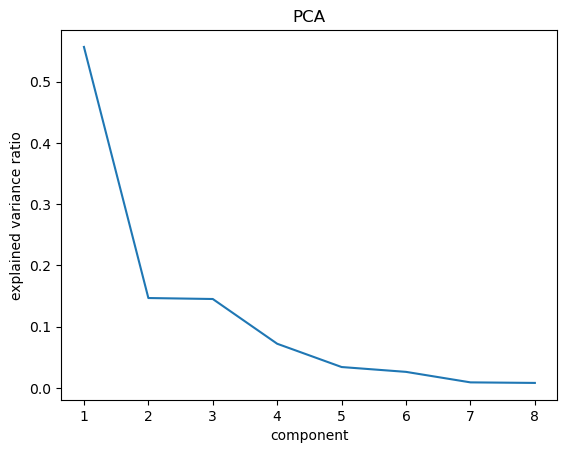

In [87]:
_, ax = plt.subplots()
ax.plot(list(range(1, N_COMPONENTS + 1)), pca.explained_variance_ratio_)
ax.set_title('PCA')
ax.set_ylabel('explained variance ratio')
ax.set_xlabel('component')
ax.set_xticks(list(range(1, N_COMPONENTS + 1)))
plt.show()

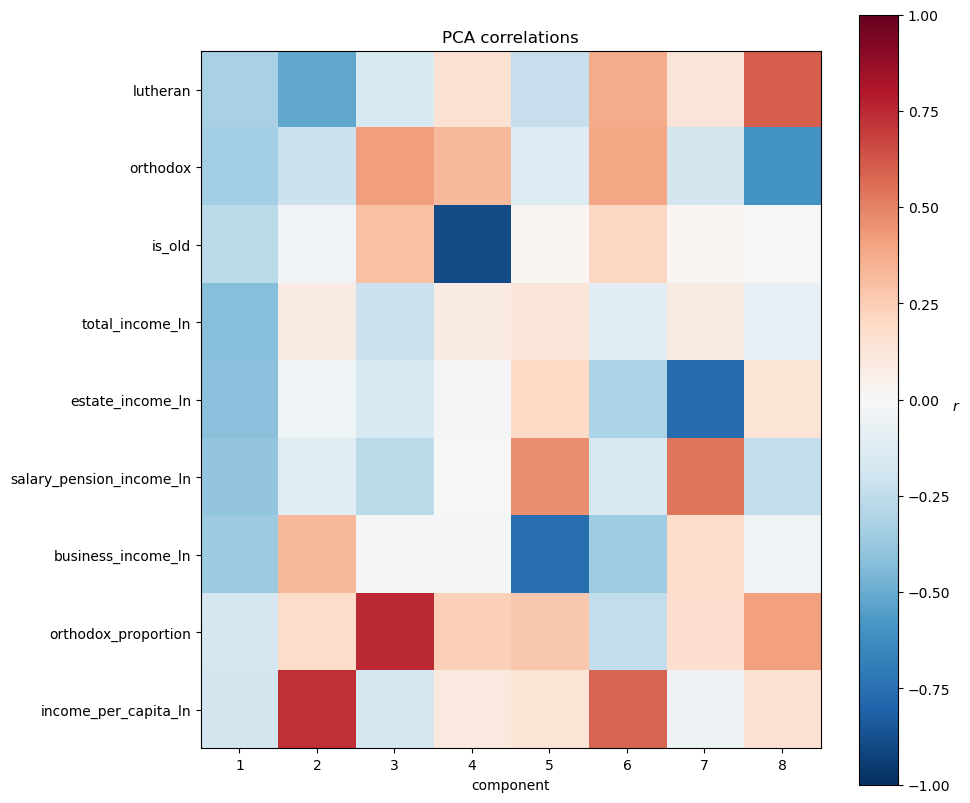

In [88]:
_, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(components, cmap='RdBu_r', vmin=-1, vmax=1)
ax.set_title('PCA correlations')
ax.set_xlabel('component')
ax.set_yticks(list(range(len(variables))))
ax.set_yticklabels(variables)
ax.set_xticks(list(range(N_COMPONENTS)))
ax.set_xticklabels(list(range(1, N_COMPONENTS + 1)))

plt.colorbar(im).ax.set_ylabel("$r$", rotation=0)

plt.show()

<AxesSubplot:>

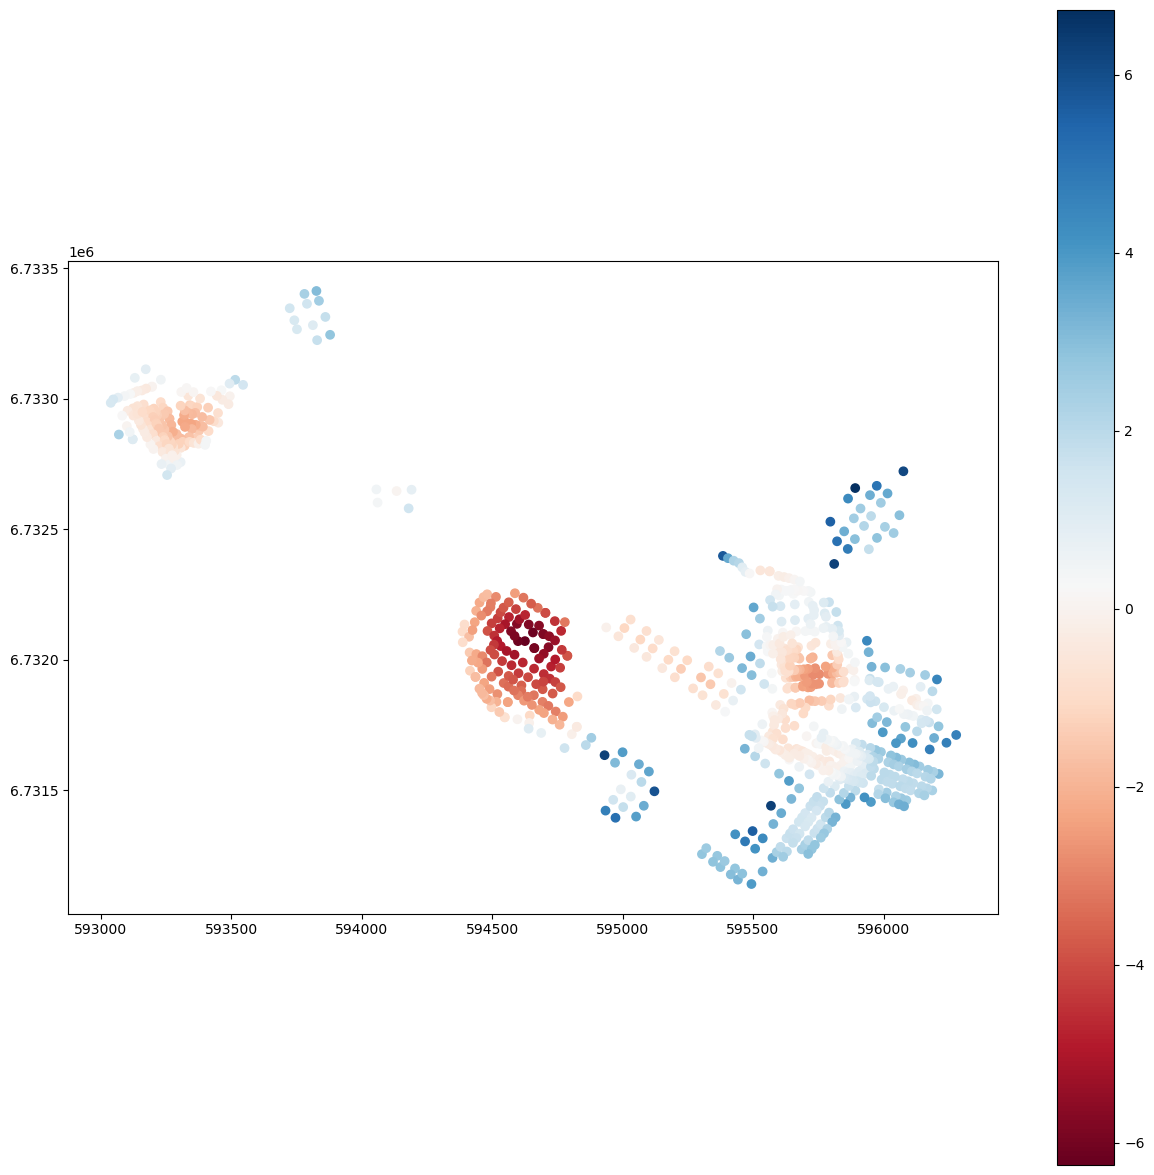

In [89]:
transformed.plot(
    column=0,
    cmap='RdBu',
    figsize=(15, 15),
    legend=True,
    # vmin=-6,
    # vmax=6,
)

<AxesSubplot:>

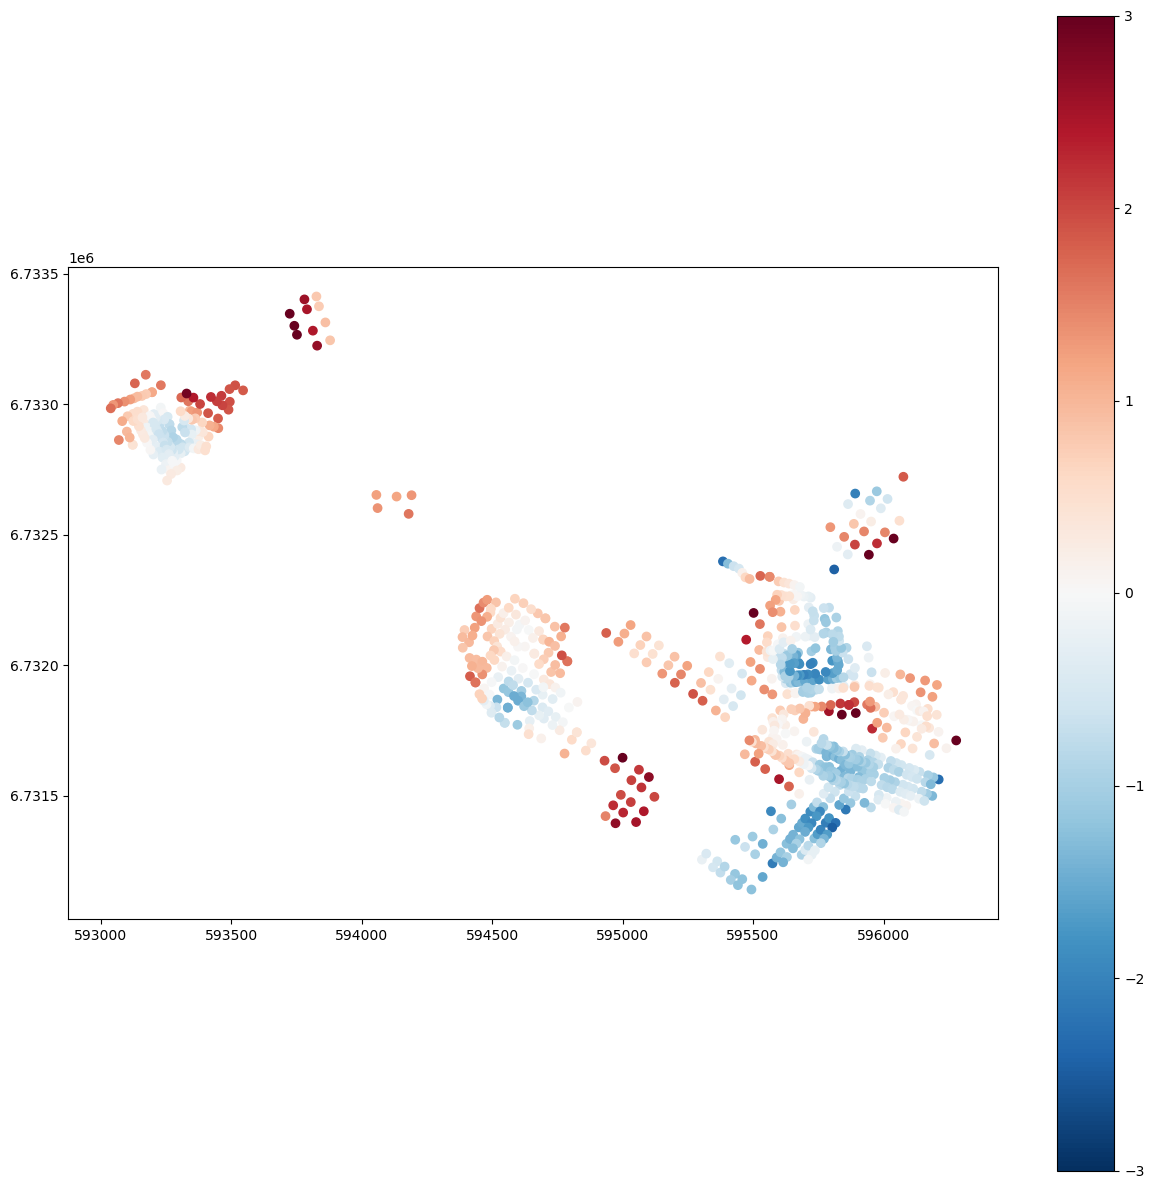

In [95]:
transformed.plot(
    column=1,
    cmap='RdBu_r',
    figsize=(15, 15),
    legend=True,
    vmin=-3,
    vmax=3,
)

<AxesSubplot:>

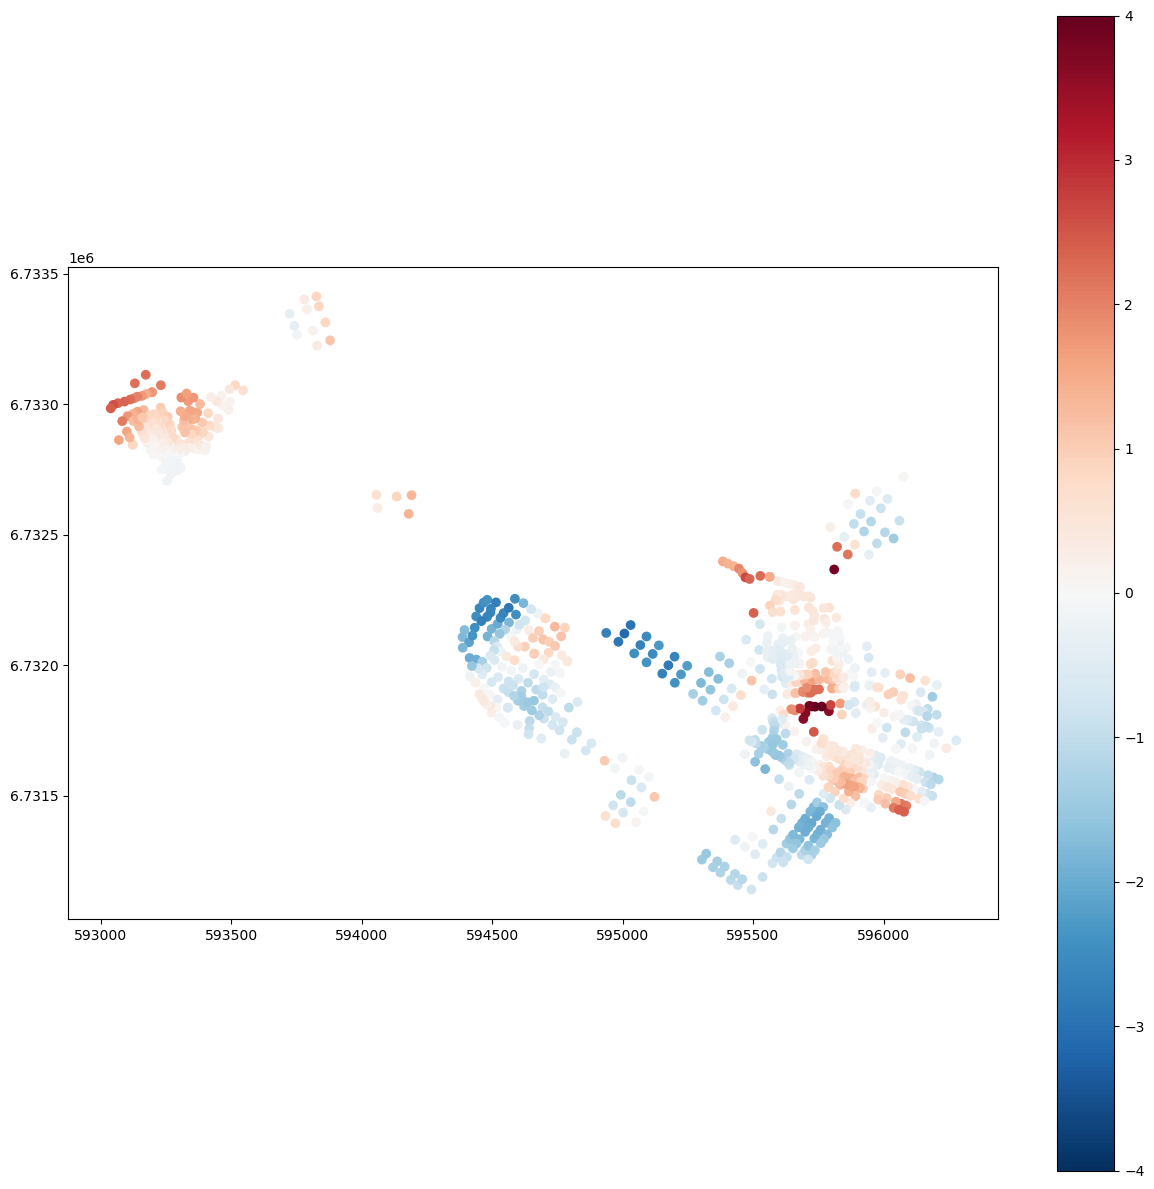

In [91]:
transformed.plot(
    column=2,
    cmap='RdBu_r',
    figsize=(15, 15),
    legend=True,
    vmin=-4,
    vmax=4,
)

<AxesSubplot:>

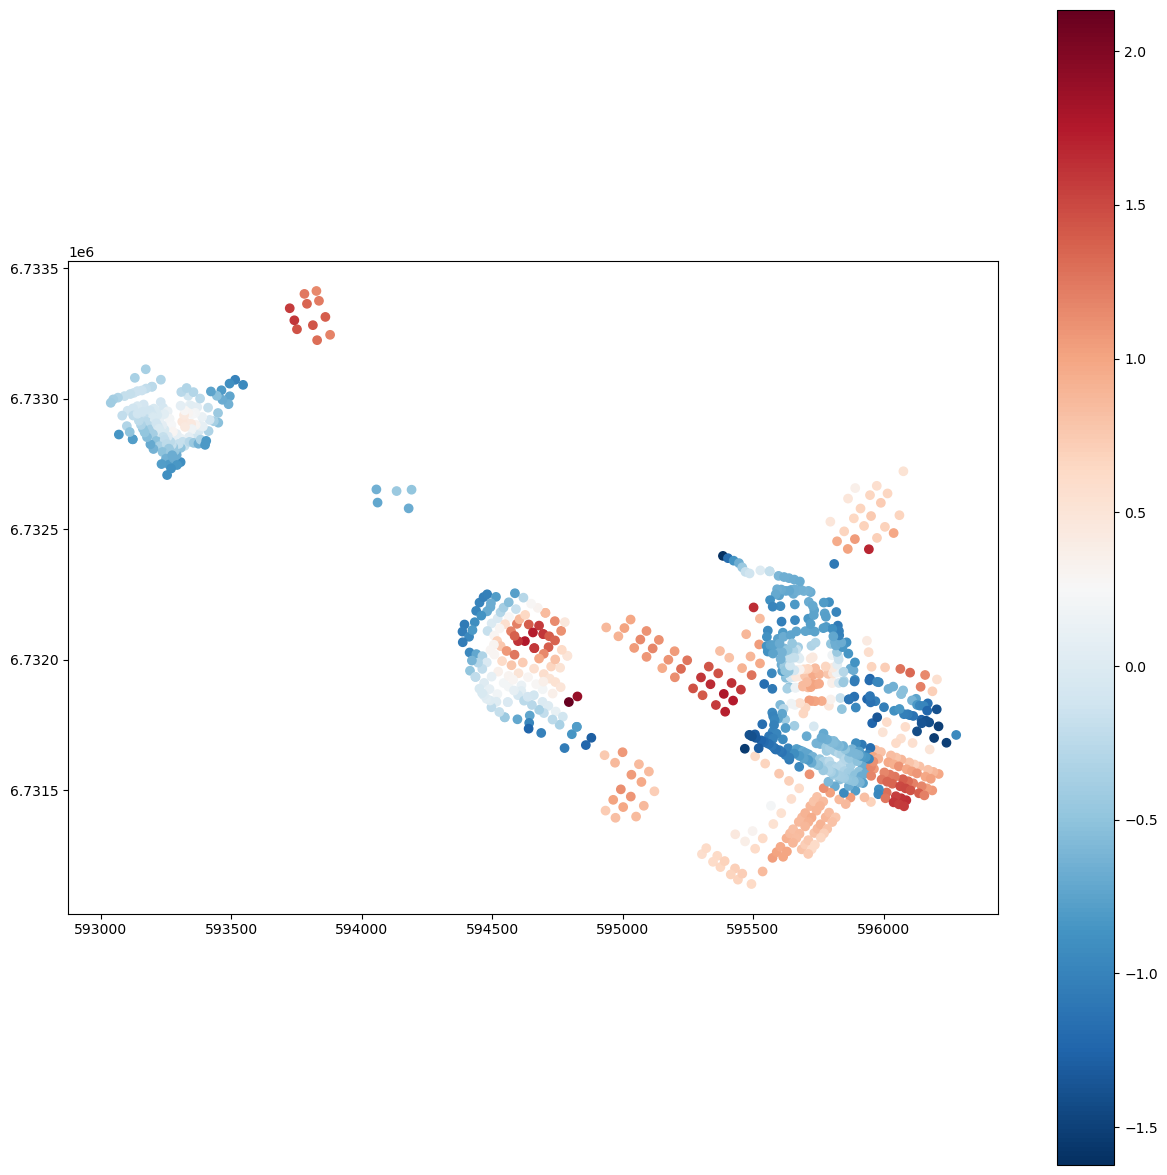

In [92]:
transformed.plot(
    column=3,
    cmap='RdBu_r',
    figsize=(15, 15),
    legend=True,
    # vmin=-3,
    # vmax=3,
)